![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

<b>Explaning the thoughts:</b>

This kind of problem seens like a one-shot-learning for face validation problem,
when you only have 1 image of a person and want to validate if this person is really 
the same person on the image, that said, here i'll try train a siamese network to learn a simylarity function from signatures, i.e., i'll randomly choose a image from genuine dataset, and try predict if this image is a genuine (G), forged (F) or disguised (D).

<b>Explaning the Siamese Neural Net (SNN):</b>
The SNNs are designed to deal with problems such as one-shot-learning and their ultimate goal is to learn a distance function between images, in which if the image shown is from the same person, assuming a T threshold, it is expected that the distance function of the model points to something less than the threshold and vice versa.
 
The structure of the SNNs is quite interesting. In short it is a convolutional network that in its last layer before the final its convolution is flattened to become a vector of attributes widely used in classic ML, from there then there is a final layer of MLP that learns the function to discriminate images.

Structure example:
<img src="utils/images/SNN_structure.png" width='500'>


References for Siamese Network are in the last cells -> [1], [2]

So basically the idea for training and testing the model is:
we passed two signatures, the standard one and the signature that should be checked and what we expect from the model is a 0 or 1 answer, 0 for the signature is true and 1 for non-true signature.

In our problem the only change was in the output, in which I adapted for him to learn a function in one-hot-encoding of the classes.

<b>Daydreams:</b> 

I chose to try this solution in this problem because I was based on a hypothetical use case in a registry office for example (I know it is not the proposed problem, but I think it is worth putting here). The hypothetical problem would be as follows:

<blockquote>
Suppose that a registry's office proposes to automate the signature authentication process of your clients, in which, when the client comes to open a firm he signs it in the way that will be considered as "standard" and then in the following times all his other signatures will be compared this.
</blockquote>

Then based on the scenario described that I proposed this solution, since initially you would only have a "standard" signature that will be the basis for comparison of the others, so here I chose this form of training, in which, it is compared to standard customer signature with the rest of the dataset, but in our case the only difference would be the number of classes at the end of the network.

<b>Addendums: </b>

i) I modified the organization of the folders to make them easier to use. What I changed was the 'Reference' folder from inside the trainingSet outside. Just so I don't have problems with the classes.

ii) There are some disadvantages to this type of approach that I have chosen. One is that for each client or better for each authenticated signature in your database, you need to train your model in 1: N, where 1 is the signature and N is the rest of the base, which does not seem like a good idea for extremily large databases. Another disadvantage is that all reference data is not used, so other ways of thinking about the problem could be thought of to improve performance. How maybe you can get rid of the anecdote and use a different image for each batch size for example.

iii) In our scenario, another type of problem that is very similar is the few-shot-learning, in which we want to claim the classification of ours classes from a few samples. What is exactly what we have here, the differences in approaches would be that we would need N images from each class (1 <N <10) and so we would follow the implementation of the methods. Something like this would circumvent the disadvantage of the previous approach in which we would need to train model 1: N. Here the only thing that would be needed to add a new class, that is, a new author with a new signature would be just a few signatures.

However, I did not choose to try this kind of approach for some reasons: 1) Although it fits better with the data we have, it does not fit the anecdote of the registry's office. 2) Searching about in the literature I did not find the results shown so interesting a priori (you k'now, attempts  ¯ \ _(ツ)_/¯ ). 3) I thought about using both, but as I didn't have that much time, I opted for just one.

<b> Appendix: </b>
 
I sent an email asking some questions about the exercise and it was clear that the proposed problem is actually a zero-shot-learning, but as I liked the pipeline and the results obtained by the model as well, I chose to send this one-shot-learning based solution nonetheless. In other words, probably in what tests that will be done with the model in the testSet will not obtain good results, however it would still be possible to solve the problem if a signature from author B were made available and used for training.

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

That said, let's go to the Pipeline!

<b>Pipeline</b>:
<blockquote> 
    <ol>
        <li>Random pick one image from REFERENCE dir -> <b>This image will be the default image for comparison.</b></li>
        <li> After that, for each class: Genuine, Disguise or Simulated, we obtained a sample of 18 for each (the number 18 was chosen due to the division of 90% for training and 10% for testing the model, but as the data must be balanced so I got 90% of the minority class, which is 'Disguised' soon, 90% of 20 out of 18). After that I created a vector whose shape is: [another_image, standard_image] and a one-hot target vector for each randomly chosen image.</li>
        <li>Train the model. </li>
        <li>See the results and made a conclusion. </li>
    </ol>
    
</blockquote>

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

1. Random pick one image from REFERENCE dir -> This image will be the default image for comparison

>I just random pick an image from reference dir

In [1]:
# importing the basic libs for see the data
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
np.random.seed(42) # set for reproducibility
reference_path = 'Reference'
image_path = np.random.choice([x for x in os.listdir(reference_path)
               if os.path.isfile(os.path.join(reference_path, x))])
one_shot_image_path = f'{reference_path}/{image_path}' # the path of "default" image

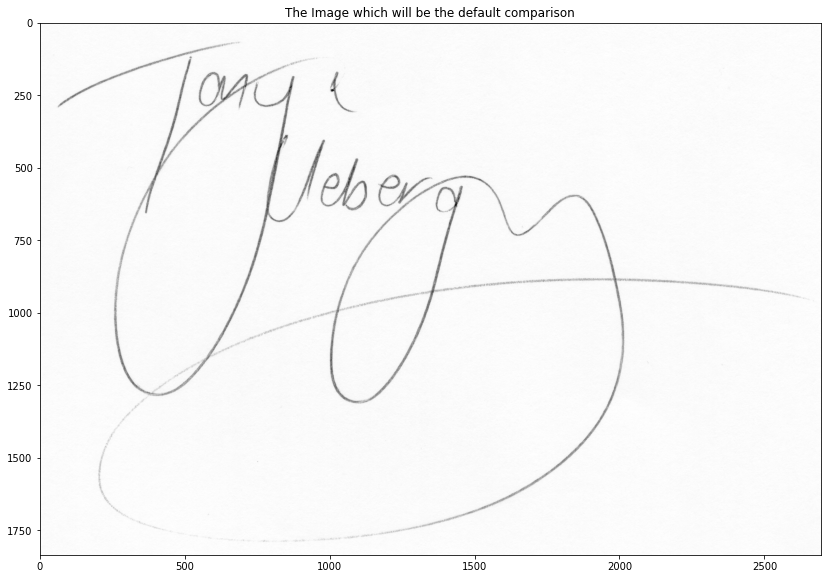

In [3]:
# Just seeing the image chosen

one_shot_image = cv2.imread(one_shot_image_path, 0)

fig, ax = plt.subplots(figsize=(14, 10))
ax.imshow(one_shot_image,  cmap='gray', vmin=0, vmax=255)
ax.set_title('The Image which will be the default comparison')
plt.show()

Here i have a addendum again: 

Looking the chosen "height, width" the image loses a lot of information, and the nice "height, width" to not lose that much information is about 224,244 which a tried. But in my 1050Ti with 4Gb the model just don't fits in memory ( щ（ﾟДﾟщ） < "Dear god why?">), so I decreases the "height, width" of images to fit in 4Gb of VRAM.

In [4]:
height, width = 140, 140
batch_size = 4
train_dir = 'TrainingSet'

In [5]:
# Creating the one-hot enconding for the 3 classes
classes = os.listdir(train_dir)
one_hot_codes_series = pd.Series(classes)
one_hot_codes = pd.get_dummies(one_hot_codes_series)
print(f'the one hot labels is: \n {one_hot_codes} \nThe column represent the class one hot')
print(f'So the {one_hot_codes.iloc[:,0].to_list()} is the representation of the class {one_hot_codes.columns[0]}')

the one hot labels is: 
    Disguise  Genuine  Simulated
0         1        0          0
1         0        1          0
2         0        0          1 
The column represent the class one hot
So the [1, 0, 0] is the representation of the class Disguise


![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

2. After that, for each class: Genuine, Disguise or Simulated, we obtained a sample of 18 for each (the number 18 was chosen due to the division of 90% for training and 10% for testing the model, but as the data must be balanced so I got 90% of the minority class, which is 'Disguised' soon, 90% of 20 out of 18). After that I created a vector whose shape is: [another_image, standard_image] and a one-hot target vector for each randomly chosen image.

First cell:
>just sample the data of each class

Third cell
>Creating the vectors

In [6]:
# Just sample the data of each class

sampled_files = []
len_sample = 18

for clas in classes:
    images = os.listdir(f'{train_dir}/{clas}')
    
    # if the number os samples is great then number of images in the class
    # the samples is all images in that class
    if (len(images) < len_sample):
        sampled_images = images
    else:
        sampled_images = np.random.choice(images, len_sample, replace=False)
        
    all_dir_and_class_sampled_images = [] # a list to contain of
                                          # all sampled images (path_img, class_of_image)
    for img in sampled_images:
        dir_images = f'{train_dir}/{clas}/{img}'
        all_dir_and_class_sampled_images.append([dir_images, clas])
        
    sampled_files.append(all_dir_and_class_sampled_images)

#  just flat the list of classes
sampled_files = [file for clas in sampled_files for file in clas]

In [7]:
import tensorflow as tf

# A function to augment images
# the augmentyation methods are: resize_with_crop_or_pad, random_crop and random_brightness
# this funtion recieves: 
# img: tensor of shape [width, heigt, channels]
# 
# return a augmentade image

def augment(img):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img, height + 6, width + 6) 
    img = tf.image.random_crop(img, size=[height, width, 1])
    img = tf.image.random_brightness(img, max_delta=0.3)
    return np.squeeze(img, axis=2)

In [8]:
# Creating the vector shape of type:
#     [(batch_size, image, default_image)] -> shape is: (2, batch_size, image, default_img)
#     [(batch_size, one-hot-encoding)]

from tensorflow import keras
from tensorflow.keras.preprocessing import image
import pandas as pd

# image_generator_for_siamese_network function:
# this generator function recieve:
#     dir: str, the directory name for training images
#     batch_size: int, the batch size of generator
#     height: int, the height of loaded image
#     width: int, the width of loaded image
#
# return a batch of batch_x, batch_y of shape:
#     batch_x: [(2, batch_size, height, width, 1)]
#     batch_y: [(batch_size, len(classes in dir))] => example: [(2, 3)] = [[0,1,0],[1,0,0]]

def image_generator_for_siamese_network(dir, batch_size, height, width):
    classes = os.listdir(dir) # each subdirectory is a class
    np.random.seed(42) # for reproducibility
    
    # generate the one hot
    one_hot_codes_series = pd.Series(classes)
    one_hot_codes = pd.get_dummies(one_hot_codes_series)
    
    np.random.shuffle(sampled_files) # just shuffle
    img_i = 0 # index for the next return image
    
    # load the default image
    one_shot_image_default = image.load_img(one_shot_image_path,
                                           color_mode='grayscale',
                                           target_size=(height, width))
    
    one_shot_image_default = image.img_to_array(one_shot_image_default) # convert to numpy

    # normalize the default image => [0,1]
    one_shot_image_default /= 255.
    
    while True:
        # the actually batch
        batch_images = []
        batch_targets = []
        stack_one_shot_image_default = [] # this is for generate the right format for feed the model
                                          # the right format is:
                                          # [(batch_size, heigth, width, 1), (batch_size, heigth, width, 1)]
                                          # left is the images to compare
                                          # right is the "default" image in stack
        while len(batch_images) < batch_size and img_i < len(sampled_files):

            # select the image
            img_path = sampled_files[img_i][0]
            img_cls = sampled_files[img_i][1]
            img = image.load_img(img_path, 
                                 color_mode='grayscale',
                                 target_size=(height, width))
            img = image.img_to_array(img) # convert to numpy

            # normalize the image => [0,1]
            img /= 255.
            
            img = augment(img) # augment the image
            
            # insert on batch
            batch_images.append(img) 
            batch_targets.append(img_cls)
            stack_one_shot_image_default.append(one_shot_image_default)
            img_i += 1 # next image
        
        batch_targets_one_hot = []
        
        for y_targ in batch_targets:
            batch_targets_one_hot.append(one_hot_codes[y_targ].to_list())

        batch_images_plus_one_shot = [np.array(batch_images), np.array(stack_one_shot_image_default)]
        
        yield batch_images_plus_one_shot, np.array(batch_targets_one_hot)
        
        # In the end of a epoch, begins again
        if img_i >= len(sampled_files):
            img_i = 0

In [9]:
# Instance of the generator for training

train_generator = image_generator_for_siamese_network(train_dir, batch_size, height, width) 

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

3. Train the model.

<blockquote>
    Generate too a Test set
</blockquote>

In [10]:
# Creating the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal

def get_siamese_model(input_shape):
    
    np.random.seed(42)
    """
        Model architecture
    """
    
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    initialize_weights = RandomNormal(mean=0.0, stddev=0.01, seed=42)
    
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    initialize_bias = RandomNormal(mean=0.5, stddev=0.01, seed=42)
    
    # Define the tensors for the two input images
    left_input = Input(input_shape, name = 'I1')
    right_input = Input(input_shape, name = 'I2')
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(3,activation='sigmoid',bias_initializer=initialize_bias, name='Out')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

model = get_siamese_model((height, width, 1))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I1 (InputLayer)                 [(None, 140, 140, 1) 0                                            
__________________________________________________________________________________________________
I2 (InputLayer)                 [(None, 140, 140, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         106056512   I1[0][0]                         
                                                                 I2[0][0]                         
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]      

In [11]:
# Compiling the model

from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr = 0.00006)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["CategoricalAccuracy"])

model.input_shape, model.output_shape

([(None, 140, 140, 1), (None, 140, 140, 1)], (None, 3))

In [12]:
test_files = [] # all test images

for clas in classes: # separate all images for each class which is not in the sampled ones
    images = os.listdir(f'{train_dir}/{clas}')
    all_dir_and_class_sampled_images = []
    for img in images:
        dir_images = f'{train_dir}/{clas}/{img}'
        all_dir_and_class_sampled_images.append([dir_images, clas])
    test_files.append(all_dir_and_class_sampled_images)
    
# just flat the list
test_files = [file for clas in test_files for file in clas if file not in sampled_files]

In [13]:
# Preparing Test data for test

X_test = [] # Test images
y_test = [] # Test labels
batch_targets = [] #aux to create the y_test
stack_one_shot_image_default = [] # stack of 'default' image

# load the default image
one_shot_image_default = image.load_img(one_shot_image_path,
                                       color_mode='grayscale',
                                       target_size=(height, width))

one_shot_image_default = image.img_to_array(one_shot_image_default) # convert to numpy

for test_image in test_files:
    # select the image
    img_path = test_image[0]
    img_cls = test_image[1]
    img = image.load_img(img_path, 
                         color_mode='grayscale',
                         target_size=(height, width))
    img = image.img_to_array(img) # convert to numpy

    # normalize the image => [0,1]
    img /= 255.

    # insert on batch
    X_test.append(img) 
    batch_targets.append(img_cls)
    stack_one_shot_image_default.append(one_shot_image_default)

for y_targ in batch_targets:
    y_test.append(one_hot_codes[y_targ].to_list())

test_batch = [np.array(X_test), np.array(stack_one_shot_image_default)] # the correct shape
                                                                        # for batch with
                                                                        # [images,default_img]
y_test = np.array(y_test) # convert to numpy

In [14]:
# fitting the model

model.fit(train_generator, 
          validation_data=(test_batch, np.array(y_test)),
          epochs=10, steps_per_epoch=len(sampled_files)/batch_size)

Epoch 1/10
14/13 [===============================] - 9s 635ms/step - loss: 11.0521 - categorical_accuracy: 0.2778 - val_loss: 10.2176 - val_categorical_accuracy: 0.5890
Epoch 2/10
14/13 [===============================] - 7s 530ms/step - loss: 9.8488 - categorical_accuracy: 0.3333 - val_loss: 9.0741 - val_categorical_accuracy: 0.5890
Epoch 3/10
14/13 [===============================] - 7s 531ms/step - loss: 8.7700 - categorical_accuracy: 0.4074 - val_loss: 8.2001 - val_categorical_accuracy: 0.5890
Epoch 4/10
14/13 [===============================] - 7s 520ms/step - loss: 7.8200 - categorical_accuracy: 0.5556 - val_loss: 7.3142 - val_categorical_accuracy: 0.5890
Epoch 5/10
14/13 [===============================] - 7s 525ms/step - loss: 6.9886 - categorical_accuracy: 0.5926 - val_loss: 6.6191 - val_categorical_accuracy: 0.5890
Epoch 6/10
14/13 [===============================] - 7s 530ms/step - loss: 6.2413 - categorical_accuracy: 0.6667 - val_loss: 6.5180 - val_categorical_accuracy: 0.5

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

4. See the results and made a conclusion.

<blockquote>
    Just make a confusion matrix and interpret it
</blockquote>

In [15]:
pred = model.predict(test_batch) # predictions vector

In [16]:
y_pred = [] # the class predicted
y_true = [] # the true class of test set

for i, p in enumerate(pred):
    y_pred.append(np.argmax(p))
    y_true.append(np.argmax(y_test[i]))

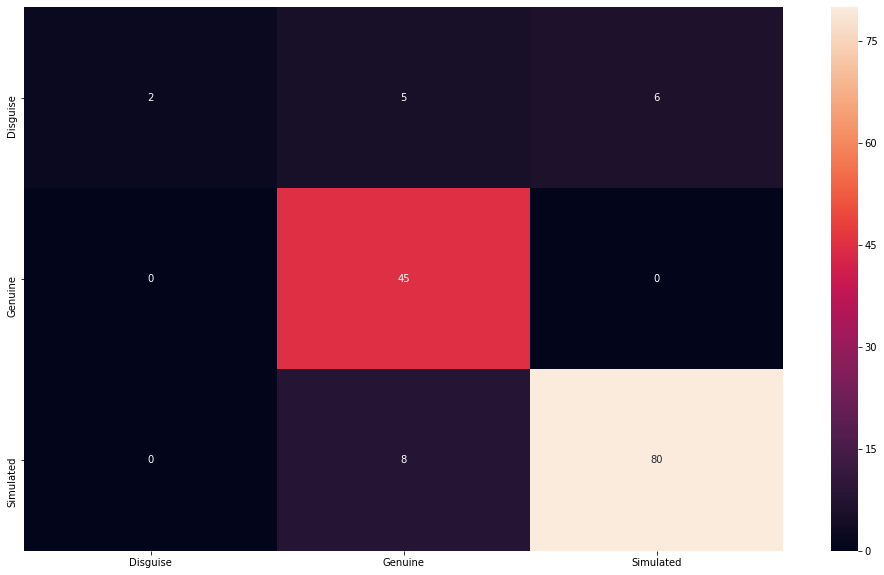

In [18]:
# Generating a confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(np.array(y_pred), np.array(y_true))

class_names = one_hot_codes.columns
fig = plt.figure(figsize=(17,10))
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d') 

##### Conclusion

All in all the model have a good results, but seens like a lot instable, sometimes we get 90% accuracy, sometimes we get 0.

Anyway the available model was trained with all data. 

REFERENCES:

[1] https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

[2] DEY, Sounak et al. Signet: Convolutional siamese network for writer independent offline signature verification. arXiv preprint arXiv:1707.02131, 2017.